In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
from sklearn.model_selection import train_test_split
from pathlib import Path
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch.nn.functional as F
import time
import kagglehub
from typing import Dict, List, Tuple
from collections import Counter
import cv2

In [2]:
# Import the preprocessed dataset
# dataset_path = kagglehub.dataset_download("parsasam/captcha-dataset")
dataset_path = "../preprocessed/"
dataset_path = Path(dataset_path)

In [3]:
# Set captcha parameters
CAPTCHA_LENGTH: int = 5  # Captchas are exactly 5 characters long
# CHAR_INDEX: int = 0  # Index of the character to predict (0-4 for 5 characters)


CHECKPOINT_DIRS = [f"char_{i}_net_checkpoints" for i in range(CAPTCHA_LENGTH)]
for dir in CHECKPOINT_DIRS:
    os.makedirs(dir, exist_ok=True)

In [31]:
CHARACTERS = "ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz0123456789"
NUM_CLASSES: int = len(CHARACTERS)
CHAR_TO_INDEX = {char: idx for idx, char in enumerate(CHARACTERS)}
INDEX_TO_CHAR = {idx: char for char, idx in CHAR_TO_INDEX.items()}

def encode_label(label: str) -> torch.Tensor:
    indices = [CHAR_TO_INDEX[char] for char in label]
    one_hot = torch.zeros(len(label), NUM_CLASSES)
    for i, index in enumerate(indices):
        one_hot[i][index] = 1
    return one_hot

def encode_char(char: str) -> torch.Tensor:
    index = CHAR_TO_INDEX[char]
    one_hot = torch.zeros(NUM_CLASSES)
    one_hot[index] = 1.0
    return one_hot

def decode_label(one_hot: torch.Tensor) -> str:
    decoded_chars = []
    for i in range(one_hot.size(0)):
        index = torch.argmax(one_hot[i]).item()
        decoded_chars.append(INDEX_TO_CHAR[index])
    return ''.join(decoded_chars)

def decode_char(one_hot: torch.Tensor):
    indices = torch.argmax(one_hot, dim=1)
    return [CHARACTERS[idx.item()] for idx in indices]

# Test encoding and decoding
label = "B"
encoded_label = encode_label(label)
print("Encoded Label:\n", encoded_label)

encoded_char = encode_char(label)
print(f"Encoded Char:\n {encoded_char}")

decoded_label = decode_label(encoded_label)
print("Decoded Label:", decoded_label)


Encoded Label:
 tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.]])
Encoded Char:
 tensor([0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.])
Decoded Label: B


In [5]:
# PyTorch DataLoader with image processing
transform = transforms.Compose([
    transforms.Resize((40, 150)),
    transforms.ToTensor()
])

class CaptchaDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.img_dir = img_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(img_dir) if f.endswith('.jpg')]  # Assuming .jpg files
        self.num_chars = CAPTCHA_LENGTH

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        label = img_name.split('.')[0]  # Extract label from filename (without the .jpg extension)
        img_path = os.path.join(self.img_dir, img_name)

        # Open the image and apply the transform (if any)
        image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        image = Image.fromarray(image)
        if self.transform:
            image = self.transform(image)
            
        label = [encode_char(char) for char in label]

        return image, label

In [6]:
# Create the dataset and dataloaders
dataset = CaptchaDataset(img_dir=dataset_path, transform=transform)

train_ratio = 0.8
test_ratio = 1 - train_ratio

# Split the dataset into training and testing sets
train_size = int(len(dataset) * train_ratio)
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [7]:
# CNN to try and identify a single character
class SingleCharCaptchaCNN(nn.Module):
    def __init__(self, char_idx:int):
        super(SingleCharCaptchaCNN, self).__init__()
        
        self.char_idx = char_idx

        # Define the individual convolutional layers
        # self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)    # 1 for black and white
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)

        # Define the MaxPool layers
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Dummy input to calculate the output size after convolutions
        self.dummy_input = torch.zeros(1, 1, 40, 150)  # Example input size: (batch_size, channels, height, width)
        conv_output = self._forward_conv(self.dummy_input)  # Get output shape after convolution
        conv_output_size = conv_output.view(1, -1).size(1)  # Flatten the output and get size

        # Define fully connected layers
        self.fc1 = nn.Linear(conv_output_size, 256)
        self.fc2 = nn.Linear(256, CAPTCHA_LENGTH * NUM_CLASSES)
        self.fc3 = nn.Linear(CAPTCHA_LENGTH * NUM_CLASSES, NUM_CLASSES)

    def _forward_conv(self, x):
        # Pass through the convolutional layers
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool1(x)

        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool2(x)

        x = self.conv3(x)
        x = F.relu(x)
        x = self.pool3(x)

        return x

    def forward(self, x):
        # Pass through convolution layers
        x = self._forward_conv(x)

        # Flatten the output of the convolutional layers
        x = x.flatten(start_dim=1)

        # Pass through fully connected layers
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)

        # Reshape to match the desired output format
        return x.view(-1, NUM_CLASSES)

In [8]:
# Training setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

models = [SingleCharCaptchaCNN(char_idx=i).to(device) for i in range(CAPTCHA_LENGTH)]
optimizers = [torch.optim.Adam(model.parameters(), lr=0.001) for model in models]
criterions = [nn.BCEWithLogitsLoss() for _ in models]

In [36]:
# Function to look for and load any checkpoints
def load_checkpoint(models, optimizers, checkpoint_dirs=CHECKPOINT_DIRS):
    # List all checkpoint files in the directory
    loss_history = []
    
    for i in range(CAPTCHA_LENGTH):
        checkpoint_dir = f"char_{i}_net_checkpoints"
        checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.endswith(".pth")]
        
        if not checkpoint_files:
            print(f"No checkpoints found for char {i}. Starting fresh.")
            return models, optimizers, 0, None
        
                
        latest_checkpoint = max(checkpoint_files, key=lambda f: int(f.split('_')[1][1:]))
        checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)
        
        checkpoint = torch.load(checkpoint_path)
        
        models[i].load_state_dict(checkpoint['model_state_dict'])
        optimizers[i].load_state_dict(checkpoint['optimizer_state_dict'])
        
        starting_epoch = checkpoint['epoch']
        loss_history.append(checkpoint['loss_history'])
    
    return models, optimizers, starting_epoch, loss_history


In [37]:
# Load checkpoints
model, optimizer, start_epoch, loss_history = load_checkpoint(models, optimizers)

if loss_history:
    print(f"Loss history length: {len(loss_history[0])}")

Loss history length: 5668


In [38]:
# Model training function
def train_model(models, train_loader, optimizers, criterions, epochs=10,
                print_every=100, checkpoint_dirs=CHECKPOINT_DIRS, starting_epoch=0, loss_history=None):
    if loss_history is None:
        loss_history = [[] for _ in range(CAPTCHA_LENGTH)]  # Initialize loss history if not provided

    total_batches = len(train_loader)  # Total number of batches per epoch

    # Ensure the checkpoints directory exists
    for dir in checkpoint_dirs:
        os.makedirs(dir, exist_ok=True)

    for model in models:
        model.train()
    
    for epoch in range(starting_epoch, epochs):  # Start from the checkpoint's epoch
        last_print_time = time.time()
        
        for batch_idx, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = [label.to(device) for label in labels]

            for i in range(CAPTCHA_LENGTH):
                optimizers[i].zero_grad()
                outputs = models[i](images)
                
                loss = criterions[i](outputs, labels[i])
                loss.backward()
                optimizers[i].step()

                loss_history[i].append(loss.item())

            # Print loss and total elapsed time at specified frequency
            if batch_idx % print_every == 0:
                current_time = time.strftime("%H:%M:%S")
                
                curr_t = time.time()
                elapsed_time = round(curr_t - last_print_time)
                last_print_time = curr_t
                
                print(f"{current_time} [+{elapsed_time}s]: Epoch [{epoch+1:2}/{epochs}], Batch [{batch_idx+1:4}/{total_batches}], Loss: {[format(x[-1], '.4f') for x in loss_history]}")

        # Save checkpoint at the end of the epoch
        for i in range(CAPTCHA_LENGTH):
            checkpoint_filename = f"model_e{epoch+1}_c{i}.pth"
            checkpoint_path = os.path.join(checkpoint_dirs[i], checkpoint_filename)

            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': models[i].state_dict(),
                'optimizer_state_dict': optimizers[i].state_dict(),
                'loss_history': loss_history[i],
            }, checkpoint_path)
            print(f"Saved model checkpoint for epoch [{epoch+1}/{epochs}] to {checkpoint_filename}")

    return loss_history


In [39]:
# Train the model
history = train_model(
    models=models,
    train_loader=train_dataloader,
    optimizers=optimizers,
    criterions=criterions,
    epochs=10,
    print_every=100,
    checkpoint_dirs=CHECKPOINT_DIRS,
    starting_epoch=start_epoch,
    loss_history=loss_history
)

21:50:11 [+0s]: Epoch [ 3/10], Batch [   1/2827], Loss: ['0.0214', '0.0394', '0.0405', '0.0431', '0.0182']
21:50:43 [+32s]: Epoch [ 3/10], Batch [ 101/2827], Loss: ['0.0289', '0.0430', '0.0416', '0.0515', '0.0235']
21:51:15 [+32s]: Epoch [ 3/10], Batch [ 201/2827], Loss: ['0.0241', '0.0417', '0.0498', '0.0480', '0.0315']
21:51:47 [+32s]: Epoch [ 3/10], Batch [ 301/2827], Loss: ['0.0210', '0.0315', '0.0342', '0.0420', '0.0232']
21:52:19 [+32s]: Epoch [ 3/10], Batch [ 401/2827], Loss: ['0.0330', '0.0424', '0.0386', '0.0400', '0.0295']
21:52:51 [+32s]: Epoch [ 3/10], Batch [ 501/2827], Loss: ['0.0247', '0.0394', '0.0426', '0.0455', '0.0338']
21:53:23 [+32s]: Epoch [ 3/10], Batch [ 601/2827], Loss: ['0.0282', '0.0359', '0.0387', '0.0483', '0.0269']
21:53:55 [+32s]: Epoch [ 3/10], Batch [ 701/2827], Loss: ['0.0297', '0.0396', '0.0401', '0.0335', '0.0380']
21:54:27 [+32s]: Epoch [ 3/10], Batch [ 801/2827], Loss: ['0.0266', '0.0422', '0.0451', '0.0414', '0.0311']
21:54:59 [+32s]: Epoch [ 3/10

KeyboardInterrupt: 

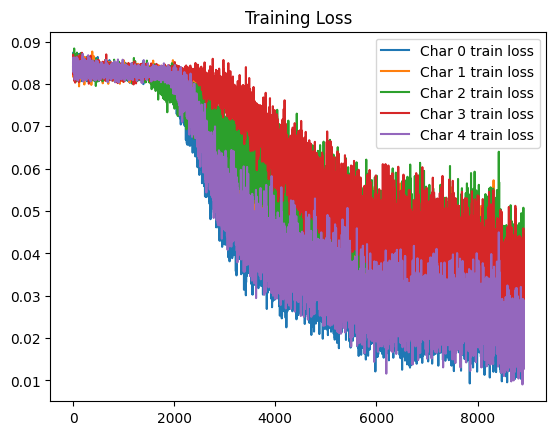

In [40]:
# Function to plot training results
def plot_results(history):
    for i, series in enumerate(history):
        plt.plot(series[50:], label=f"Char {i} train loss")
    
    plt.legend()
    plt.title('Training Loss')
    plt.show()

plot_results(loss_history)

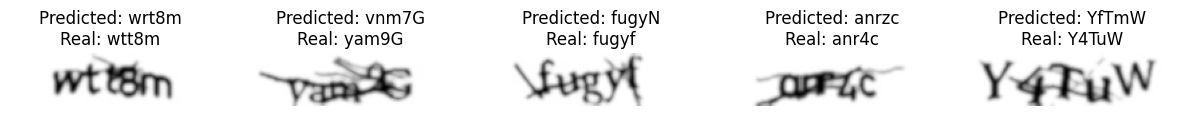

In [50]:
# Function to predict labels from the model
def predict(models, dataloader, device):
    for model in models:
        model.eval()
    
    images, labels = next(iter(dataloader))
    images = images.to(device)
    
    all_outputs = []
    with torch.no_grad():
        for model in models:
            output = model(images).squeeze(1)
            all_outputs.append(output)
    
    predicted_labels = []
    for output in all_outputs:
        decoded_chars = decode_char(output)
        predicted_labels.append(decoded_chars)
        
    predicted_labels = np.array(predicted_labels)
    predicted_labels = predicted_labels.T
    predicted_labels = [''.join(chars) for chars in predicted_labels]
    
    real_labels = []
    for label in labels:
        decoded_chars = decode_char(label)
        real_labels.append(decoded_chars)
        
    real_labels = np.array(real_labels)
    real_labels = real_labels.T
    real_labels = [''.join(chars) for chars in real_labels]
    
    return images, predicted_labels, real_labels
        
    

# Get some images and their predicted labels
images, predicted_labels, real_labels = predict(models, test_dataloader, device)

# Display a few images and their predicted labels
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(images[i+5].permute(1, 2, 0), cmap='gray')
    ax.set_title(f"Predicted: {predicted_labels[i+5]}\nReal: {real_labels[i+5]}")
    ax.axis('off')
plt.show()

In [57]:
# Test the accuracy of the model
def evaluate_model(models, dataloader, device):
    for model in models:
        model.eval()
    
    results = {
        "total_captchas": 0,
        "captcha_results": [],
    }
    
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            
            all_outputs = []
            for model in models:
                output = model(images).squeeze(1)
                all_outputs.append(output)
            
            predicted_labels = []
            for output in all_outputs:
                decoded_chars = decode_char(output)
                predicted_labels.append(decoded_chars)
                
            predicted_labels = np.array(predicted_labels)
            predicted_labels = predicted_labels.T
            predicted_labels = [''.join(chars) for chars in predicted_labels]
            
            real_labels = []
            for label in labels:
                decoded_chars = decode_char(label)
                real_labels.append(decoded_chars)
                
            real_labels = np.array(real_labels)
            real_labels = real_labels.T
            real_labels = [''.join(chars) for chars in real_labels]
            
            for pred, real in zip(predicted_labels, real_labels):
                match = [p == r for p, r in zip(pred, real)]
                results['captcha_results'].append(match)
            
            results['total_captchas'] = results['total_captchas'] + 1
                    
        return results

results = evaluate_model(model, test_dataloader, device)

In [18]:
# Print test results
print(f"Correct Letters: {results["correct_letters"]}/{results["total_letters"]} ({results["correct_letters"]/results["total_letters"]:.2%})")

Correct Letters: 16412/22613 (72.58%)


In [ ]:
result_matches = np.array(results['captcha_results'])

position_accuracy = np.mean(result_matches, axis=0) * 100

correct_counts = np.sum(result_matches, axis=1)
accuracy_dist = {
    f"{i}/5": np.sum(correct_counts == i) / len(correct_counts) * 100
    for i in range(6)
}

print(accuracy_dist)
print(position_accuracy)

{'0/5': np.float64(2.9982753283509482), '1/5': np.float64(10.432052359262372), '2/5': np.float64(20.045991243974704), '3/5': np.float64(27.21885641002963), '4/5': np.float64(26.263653650554993), '5/5': np.float64(13.041171007827357)}
